In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchlensmaker as tlm

from xxchallenge import *

base_height = 35

# Parameters
A = tlm.parameter(-1.50)
G0 = tlm.parameter(-185)
T = tlm.parameter(11)
R = tlm.parameter(4.3)

# XY polynomial parameters
C = tlm.parameter(torch.zeros((13,13), dtype=torch.float64))
fixed_mask = torch.zeros_like(C, dtype=torch.bool)
fixed_mask[0, 0] = True  # Freeze position (0,0)
C.register_hook(lambda grad: grad.masked_fill(fixed_mask, 0.))

cylinder = tlm.ImplicitCylinder(*torch.tensor([-50/2, 50/2, 37.02/2], dtype=torch.float64).unbind())
rod_data = StoreVar(lambda data: data)

# Primary mirror
sag = tlm.SagSum([
    tlm.Parabolic(A=A, normalize=True),
    tlm.XYPolynomial(C, normalize=True)
])
primary = tlm.SagSurface(1800, sag)
primary_data = StoreVar(lambda data: data)

# Optical model
optics = tlm.Sequential(
    tlm.Gap(-1000),
    XXLightSource.load(),

    # Primary mirror
    tlm.Gap(1000-base_height),
    tlm.Translate3D(y=T),
    tlm.Rotate3D(z=R),
    primary_data,
    tlm.ReflectiveSurface(primary),

    # Fixed rod
    tlm.AbsolutePosition(x=G0),
    #tlm.Rotate3D(y=45),
    rod_data,
    NonImagingRod(cylinder),
)

#xxrender(optics, sampling={"xx": 500, "letter": "both"})

[  1/500] L= 0.27134 | grad norm= 3.071879955098557
[ 11/500] L= 0.56864 | grad norm= 4.216734601118983
[ 21/500] L= 3.73918 | grad norm= 21.827185377842635
[ 31/500] L= 2.10875 | grad norm= 15.925573972399647
[ 41/500] L= 1.84646 | grad norm= 10.403459799211092
[ 51/500] L= 0.53115 | grad norm= 4.3741001337633065
[ 61/500] L= 0.70804 | grad norm= 5.1166084243632515
[ 71/500] L= 0.12417 | grad norm= 2.6147784311972075
[ 81/500] L= 0.94961 | grad norm= 5.635190197478654
[ 91/500] L= 0.19001 | grad norm= 2.329894053856565
[101/500] L= 0.04727 | grad norm= 1.555810156678874
[111/500] L= 0.90202 | grad norm= 7.699617526284667
[121/500] L= 0.23896 | grad norm= 3.2373425854365476
[131/500] L= 0.03904 | grad norm= 1.3425103004541319
[141/500] L= 0.70543 | grad norm= 4.60208602676489
[151/500] L= 1.03528 | grad norm= 12.384506729081696
[161/500] L= 0.11715 | grad norm= 2.747122883899937
[171/500] L= 0.09152 | grad norm= 2.1434026434240288
[181/500] L= 0.25860 | grad norm= 4.781565638262892
[19

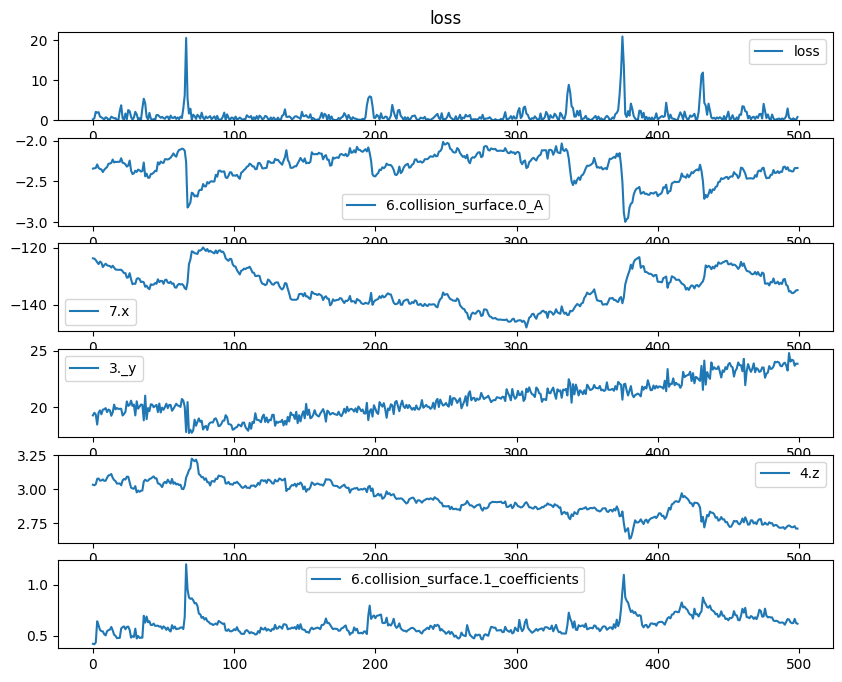

Best loss 0.0008376592304557562 at iteration 19 / 500
    3._y tensor(19.8433, dtype=torch.float64)
    4.z tensor(3.0426, dtype=torch.float64)
    6.collision_surface.0_A tensor(-2.2605, dtype=torch.float64)
    6.collision_surface.1_coefficients tensor([[ 0.0000e+00,  4.4042e-02,  4.0469e-02,  6.5432e-02, -8.3173e-02,
          1.5556e-03, -9.5921e-02,  1.4252e-03, -5.8321e-02,  2.9935e-03,
         -2.5642e-02,  2.6138e-03, -8.6197e-03],
        [-6.3577e-02, -8.6484e-02, -2.0581e-01, -2.9334e-02,  5.2362e-02,
          3.9135e-03,  5.0310e-02,  5.6641e-03,  2.7809e-02,  3.5253e-03,
          1.4034e-02,  1.9073e-03,  7.0498e-03],
        [ 2.7214e-02,  3.7217e-02, -7.4094e-02,  1.4460e-03,  6.8025e-02,
         -3.6344e-03,  4.2490e-02, -6.0820e-04,  2.0154e-02,  6.0372e-04,
          9.5296e-03,  6.9419e-04,  4.7319e-03],
        [-2.5825e-01, -4.9539e-02, -9.8470e-03, -2.2589e-02,  3.5564e-02,
         -6.4683e-03,  2.3051e-02, -1.6063e-03,  1.1833e-02, -2.4273e-04,
          5.8

In [15]:
param_groups = [
    {'params': [A], 'lr': 0.03},
    {'params': [G0], 'lr': 100},
    {'params': [T], 'lr': 25},
    {'params': [R], 'lr': 0.05},
    {'params': [C], 'lr': 0.025},
]


record = tlm.optimize(
    optics,
    optimizer = optim.SGD(param_groups),
    sampling = {"xx": 10, "disable_viewer": True, "letter": "positive"},
    dim = 3,
    num_iter = 500,
    nshow=50,
)

plot_record(record, param_groups, optics)
record.best()

print()
print("Final values")
print("A", A)
print("G0", G0)
print("T", T)
print("R", R)

# Print rod position
target = rod_data.value.target()
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())

xxrender(optics, sampling={"xx": 500, "letter": "positive"})

In [ ]:
# ideas for this models:
# regularization so that cube corners at X=-1000 are within the surface
# can be done by collinding 4 rays at the corners
# or just computing F of surface of those points

In [14]:
# Print rod position
target = rod_data.value.target()
print("ROD POSITION IN XX FRAME")
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())
rod_z = f"z{-target[0].item():.0f}"
print(rod_z)

def xxgridH(N):
    x = np.linspace(-1, 499, N)
    y = np.linspace(-499, 499, N)
    X, Y = np.meshgrid(x, y)
    return np.stack((X, Y), -1).reshape(-1, 2)

with torch.no_grad():
    part_primary = tess_mirror(xxgridH(250), primary_data.value.tf(), primary)

    # flip part around the Y=0 plane to make second part
    part_primary2 = tess_mirror(xxgridH(250), primary_data.value.tf(), primary, flipy=True)

part_sides = makesides(part_primary.vectors.dtype)

mesh.Mesh(np.concatenate([
    part_primary.data,
    part_primary2.data,
    part_sides.data
])).save(f"parabola5-double-{rod_z}.stl")



ROD POSITION IN XX FRAME
ROD X 0.0
ROD Y 0.0
ROD Z 123.67380768456366
z124
not in box tensor(6994)
not in box tensor(6994)
